Team Members: Sashi Gandavarapu & Raghu Pamidimarri

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
#Read data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sampleSubmission = pd.read_csv("sampleSubmission.csv")

target = 'Cover_Type'

#shuffle train data
train = train.sample(frac=1.0)

In [3]:
#Examine trian data
#print train[1:3]
print 'length of train data: ', len(train)
print 'length of test data: ', len(test)
print 'frequency of target variable \n' , train.Cover_Type.value_counts()

length of train data:  15120
length of test data:  565892
frequency of target variable 
7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64


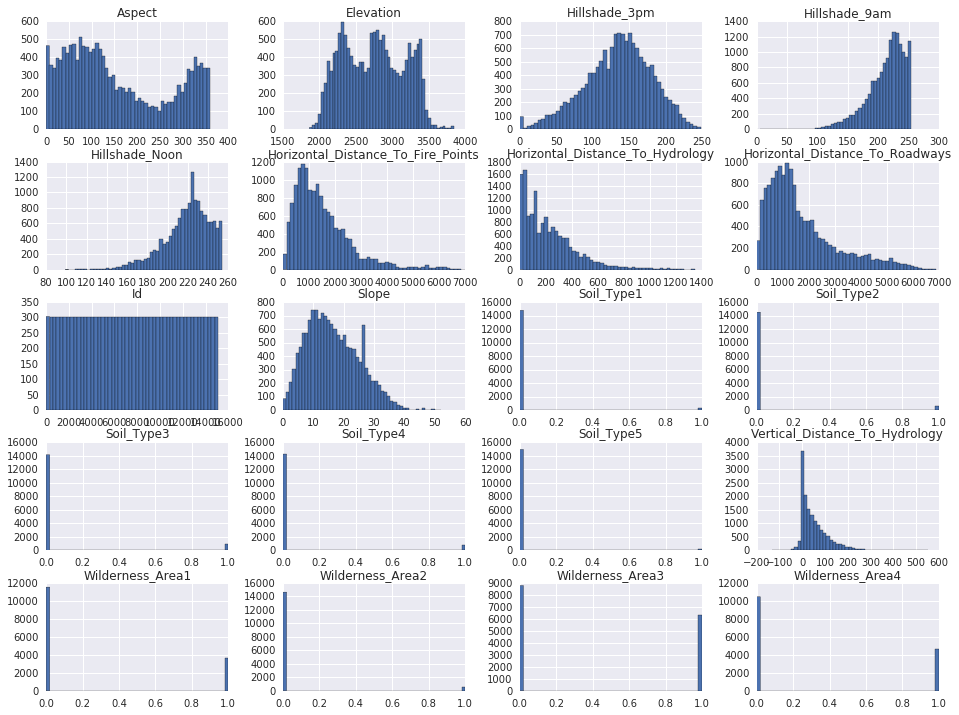

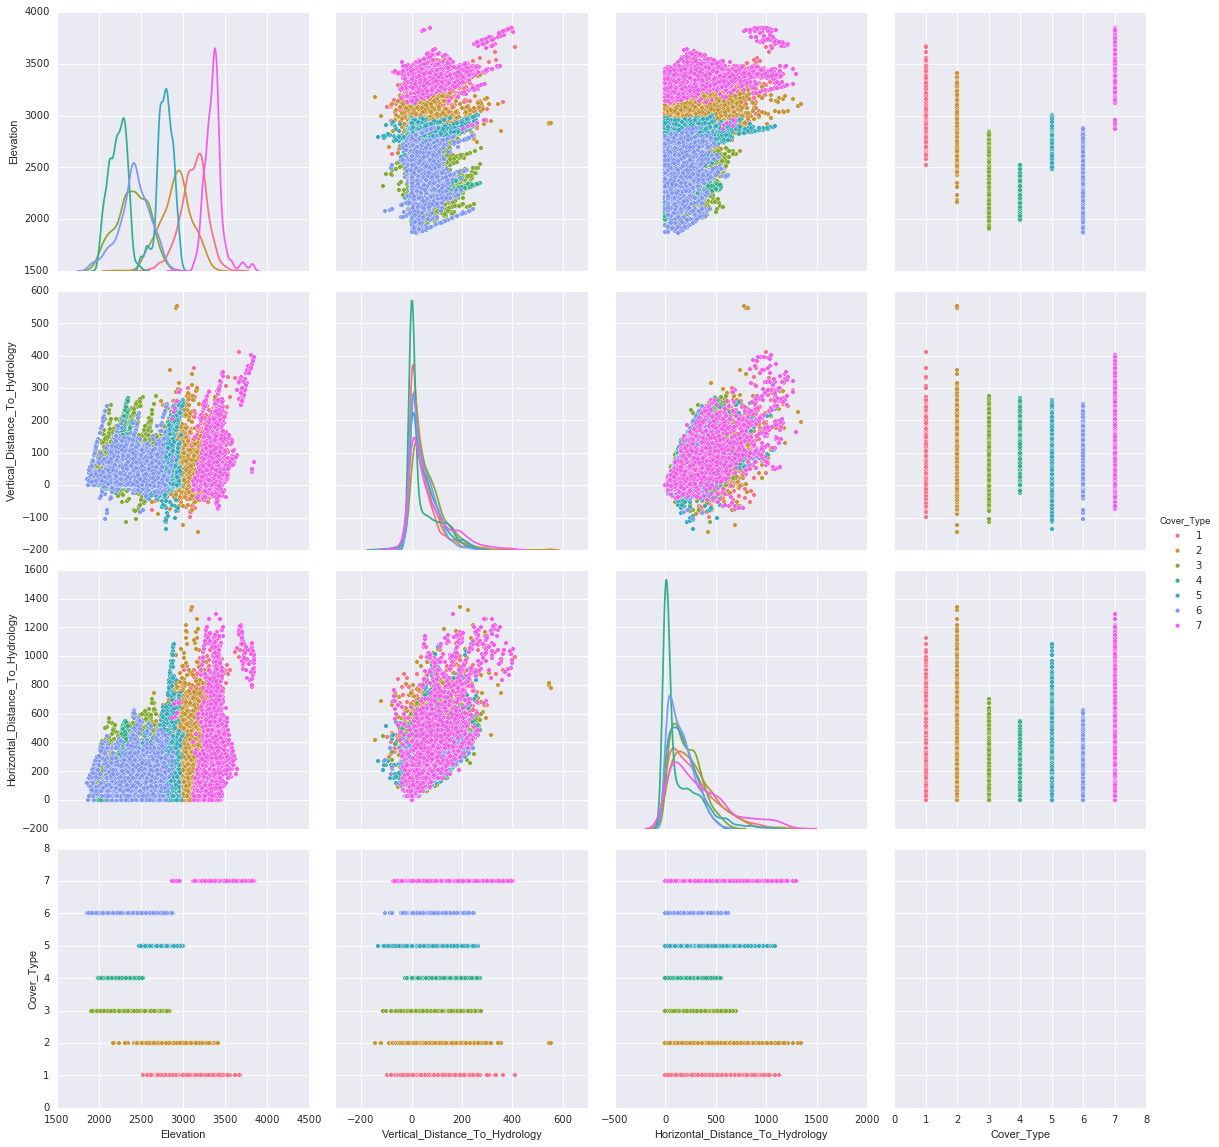

In [6]:
#Visualize the data
#Plot the histograms for the first 20 features (Which are all the numeric features and some binary features)
train.ix[:,:20].hist(figsize=(16,12),bins=50)
plt.show()

#Now, plot the relations between some interesting features
raw_features_to_plot = ['Elevation', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Cover_Type']
to_plot = train.ix[:, raw_features_to_plot]
sns.pairplot(to_plot, hue="Cover_Type", diag_kind="kde", size=4, aspect=1)

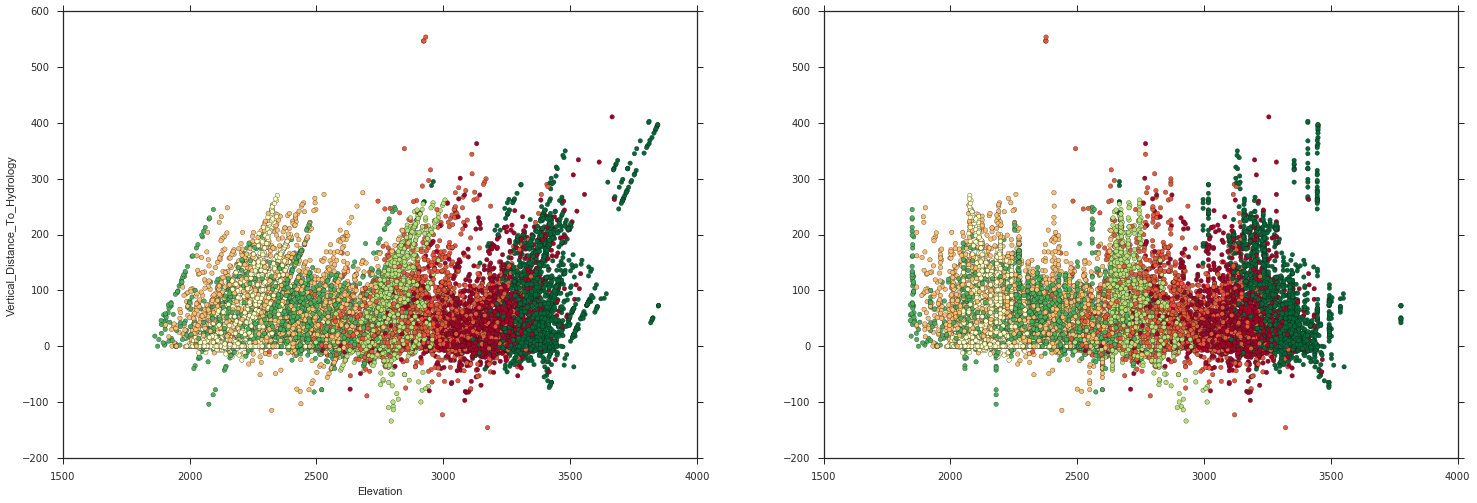

In [41]:
#Plot Elveation vs Vertical Distance to Hydrology
rcParams['figure.figsize'] = 25,8 
plt.subplot(121)
plt.scatter(train.Elevation, train.Vertical_Distance_To_Hydrology,c=np.array(list(train.Cover_Type.values)),cmap=plt.cm.RdYlGn)
plt.xlabel(train.Elevation.name)
plt.ylabel(train.Vertical_Distance_To_Hydrology.name)

plt.subplot(122)
plt.scatter(train.Elevation-train.Vertical_Distance_To_Hydrology,\
            train.Vertical_Distance_To_Hydrology,c=np.array(list(train.Cover_Type.values)),cmap=plt.cm.RdYlGn)


By shifting the scale of elevation, the cover type can be distinguished in a linear fashion.

In [7]:
#Features Engineering

#Adding these features reduces the confusion between the class 1 and class 2 which (as you would notice further down) 
#are the most confused.
def addHydrologyFeatures():
    #Vertical_Distance_To_Hydrology could be either positive or negative and this is useful information to capture
    train['BelowHydrology'] = train.Vertical_Distance_To_Hydrology < 0
    test['BelowHydrology'] = test.Vertical_Distance_To_Hydrology < 0

    #How the elevation differs from the distance to hydrology is also useful
    train['DiffElevationVertDistToHydrology'] = train.Elevation-train.Vertical_Distance_To_Hydrology
    test['DiffElevationVertDistToHydrology'] = test.Elevation-test.Vertical_Distance_To_Hydrology

    train['DiffElevationHoriDistToHydrology'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
    test['DiffElevationHoriDistToHydrology'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

    #Euclidena distance
    train['Distance_to_Hydrolody'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
    test['Distance_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

addHydrologyFeatures()

def addHigherPowerFeatures():
    train['squaredElevation'] = train['Elevation']**2
    test['squaredElevation'] = test['Elevation']**2

addHigherPowerFeatures()
    

#inspired from feature engineering in:\
#http://nbviewer.jupyter.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb

def addHydroRoadFeatures():
    train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
    test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

    train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
    test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

    train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
    test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

    train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
    test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

    train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
    test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

    train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
    test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
    
addHydroRoadFeatures()

#Make sure the angles are in the [0,180] range
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

def tweakAspect():
    train['Aspect2'] = train.Aspect.map(r)
    test['Aspect2'] = test.Aspect.map(r)
#NOTE: Do not tweak aspect - it does not help
#tweakAspect()

def tweakShades():
    train['Hillshade_9am'] = train['Hillshade_9am']/255
    test['Hillshade_9am'] = test['Hillshade_9am']/255

    train['Hillshade_Noon'] = train['Hillshade_Noon']/255
    test['Hillshade_Noon'] = test['Hillshade_Noon']/255

    train['Hillshade_3pm'] = train['Hillshade_3pm']/255
    test['Hillshade_3pm'] = test['Hillshade_3pm']/255

#NOTE: Do not tweak shades - it does not help
#tweakShades()

#There are 40 Soil type features, each of which is binary. Come up with a combination of all these features.
#NOTE: Do not know how turning this binary feature to an ordinal helps, but it does help a bit. 
#NOT USING THIS FEATURE!
def tweakSoilFeatures():
    train['Soil']=0
    test['Soil']=0
    for i in range(1,41):
        train['Soil']=train['Soil']+i*train['Soil_Type'+str(i)]
        del train['Soil_Type'+str(i)]
        test['Soil']=test['Soil']+i*test['Soil_Type'+str(i)]
        del test['Soil_Type'+str(i)]
    
#tweakSoilFeatures()

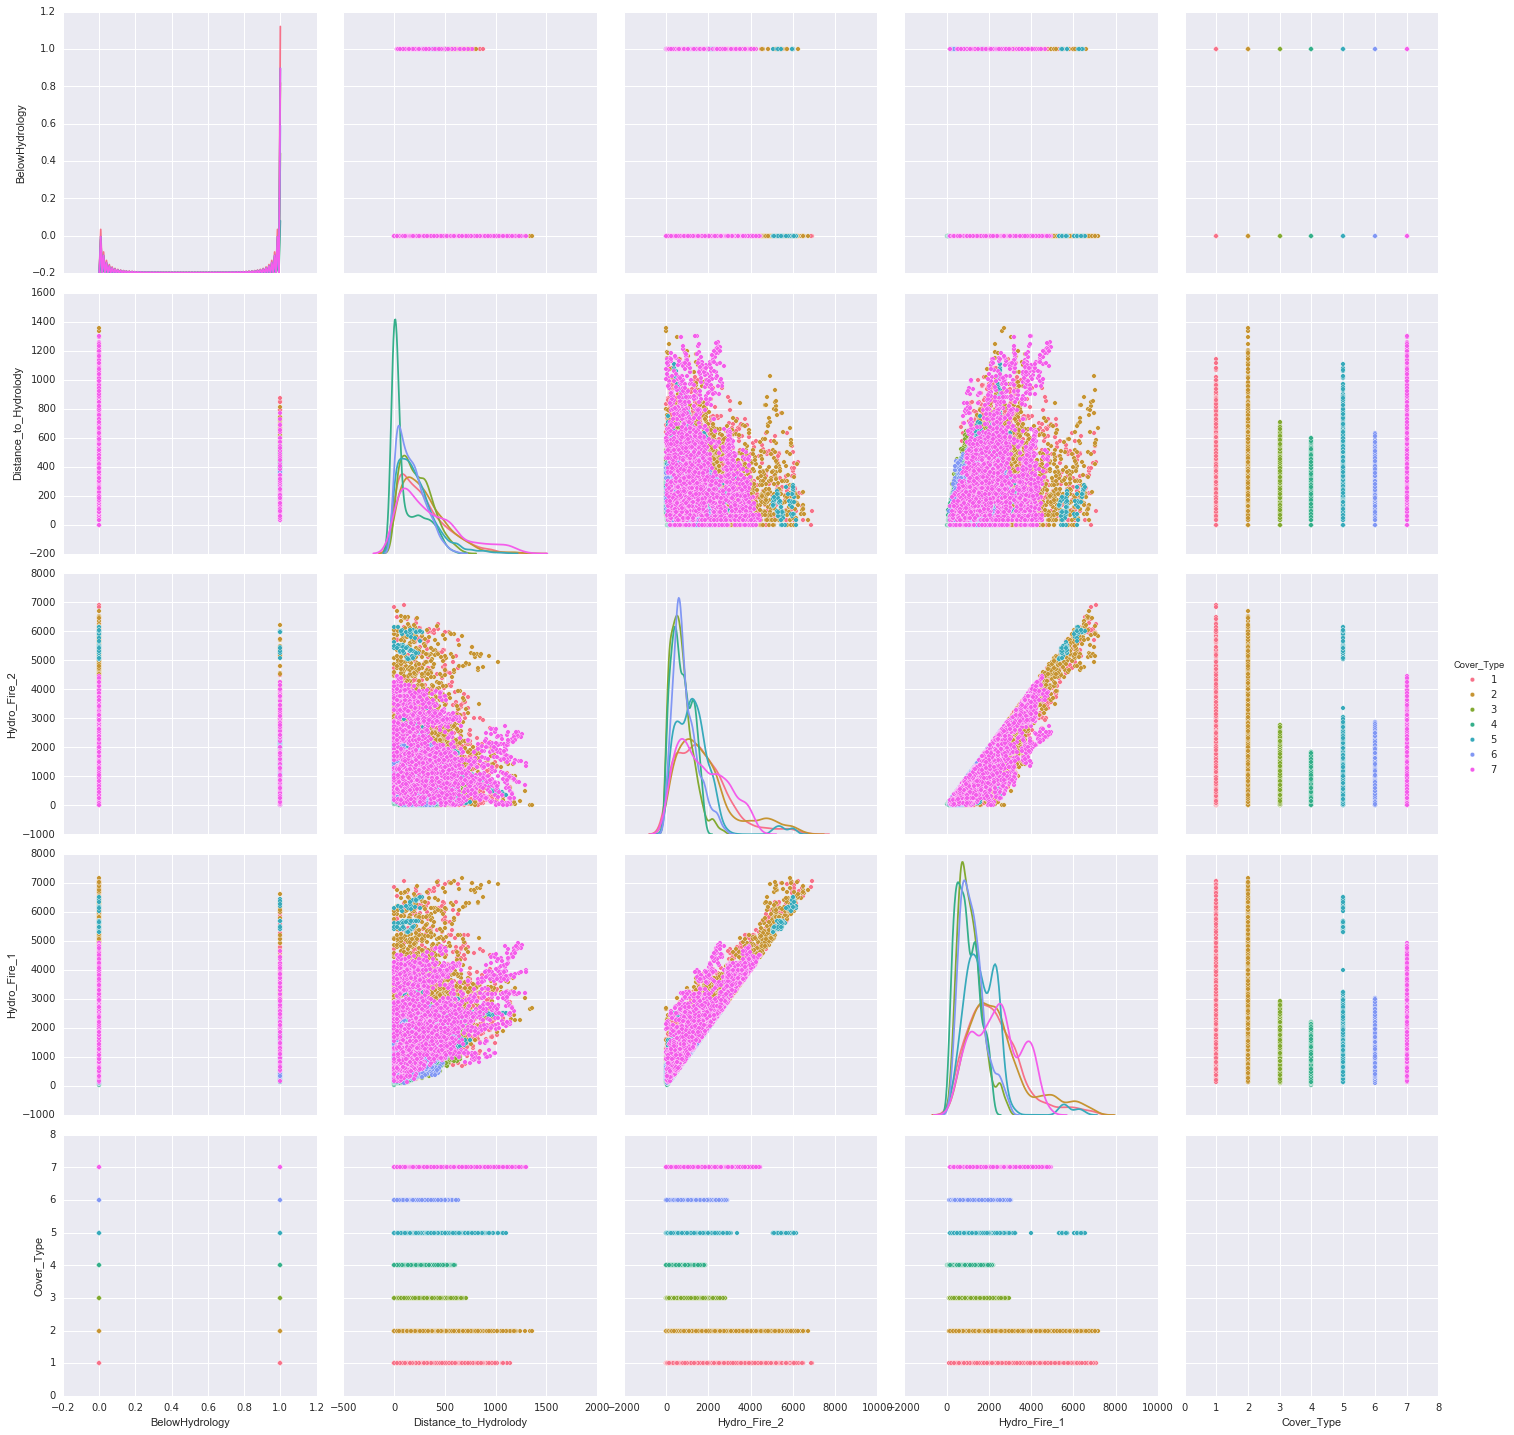

In [37]:
new_features_to_plot = ['BelowHydrology', 'Distance_to_Hydrolody', 'Hydro_Fire_2', 'Hydro_Fire_1', 'Cover_Type']
to_plot = train.ix[:, new_features_to_plot]
sns.pairplot(to_plot, hue="Cover_Type", diag_kind="kde", size=4, aspect=1)

In [12]:
IDcol = 'Id'
predictors = [x for x in train.columns if x not in [target, IDcol]]
print 'Number of features:',len(predictors)
print 'Features:', predictors

Number of features: 65
Features: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'BelowHydrology', 'DiffElevationVertDistToHydrology', 'DiffElevation

In [13]:
#Split into training and development dataset
X_fit, X_eval, y_fit, y_eval= train_test_split(train[predictors], train[target], test_size=0.1,random_state=10)

In [31]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=False, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X,Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, Y, cv=cv_folds, scoring='f1_weighted')
    
    acc = metrics.accuracy_score(Y.values, dtrain_predictions)
    
    #Print Feature Importance and metrics:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, list(X_fit.columns.values)).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        print "CV (f1) Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g \n" % \
        (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        print "Accuracy (Train): %.4g" % acc
        #print metrics.classification_report(Y.values, dtrain_predictions)
   
    return acc

In [14]:
#1. Try knn
def knn():
    knn = KNeighborsClassifier()
    print "-------knn-------------"
    modelfit(knn, X_fit, y_fit,printFeatureImportance=False)
    preds = knn.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)

    #Try GridSearch for best k
    #NOTE: 1. Best value of k is actually 1 and NOT the default 5 => accuracy increases for kNN with grid search
    #with k=1, train accuracy is 1 and dev accuracy is 0.8047
    print "-------knn grid search-------"
    kValues = {'n_neighbors': [1,2,3,4,5,100]}
    clf = GridSearchCV(KNeighborsClassifier(), kValues)
    clf.fit(X_fit, y_fit)
    kValue = clf.best_params_['n_neighbors']
    print 'Best value for k for KNN:', kValue

    print "--------trying with tuned KNN----------"
    knn_best = KNeighborsClassifier(n_neighbors=kValue)
    modelfit(knn_best, X_fit, y_fit,printFeatureImportance=False)
    preds = knn_best.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
#NOTE: Uncomment the line below to run knn, if you want to. KNN is not a good model for this project.
#knn()

In [15]:
#2. Try NB
def nb():
    bnb = BernoulliNB(binarize=0.5)
    print "-------NB-------------"
    modelfit(bnb, X_fit, y_fit,printFeatureImportance=False)
    preds = bnb.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)


    #NOTE: The best value of alpha is 0.00001 => smoothing has no impact on this. In fact, the default smoothing = 0 is better!
    alphas = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    clf = GridSearchCV(BernoulliNB(), alphas)
    clf.fit(X_fit, y_fit)
    best_alpha = clf.best_params_['alpha']
    print 'Best value for alpha:', best_alpha

    print "-------Trying tuned NB-------------"
    bnb = BernoulliNB(binarize=0.5, alpha=best_alpha)
    modelfit(bnb, X_fit, y_fit,printFeatureImportance=False)
    preds = bnb.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)

#NOTE: Uncomment the line below to run naive bayes, if you want to. Naive Bayes is not a good model for this project.
#NOTE: MULTINOMIAL NB does not work in this case - there are negative values
#nb()

In [16]:
#3. Logistic regression
#With larger samples (15k samples with only 54 features), the low bias + high variance logistic regression works better than
#the high bias, low variance naive bayes.
def logistic():
    lgr = LogisticRegression()
    print "-------Logistic Regression-------------"
    modelfit(lgr, X_fit, y_fit,printFeatureImportance=False)
    preds = lgr.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
    cValues = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
    clf = GridSearchCV(LogisticRegression(), cValues)
    clf.fit(X_fit, y_fit)
    cValue = clf.best_params_['C'] 
    print 'Best value for C for Logistic Regression:', cValue

    lgr = LogisticRegression(C=cValue, penalty='l2')
    print "-------Logistic Regression with tuned parameters-------------"
    modelfit(lgr, X_fit, y_fit,performCV=False,printFeatureImportance=False)
    preds = lgr.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
    
#NOTE: Uncomment the line below to run Logistic Regression, if you want to. Logistic Regression is not a good model for this project.    
#logistic()

In [29]:
#4. SVM
def svm():
    svm = SVC()
    print '-------SVM-------------'
    modelfit(svm, X_fit, y_fit,printFeatureImportance=False)
    preds = svm.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
    print "-------Find the best parameters for SVM-------------"
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4]}]
    #                     'C': [1, 10, 100, 1000]},
    #                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    #clf = GridSearchCV(SVC(), tuned_parameters)
    #clf.fit(X_fit, y_fit)
    #print clf.best_params_
    #The above returns {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

    print '-----------SVM with tuned parameters----------'
    svm_tuned = SVC(C=1000, gamma=0.001, kernel='rbf')
    modelfit(svm_tuned, X_fit, y_fit,performCV=False,printFeatureImportance=False)
    preds = svm_tuned.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    #print metrics.classification_report(y_eval.values, preds)
                         
#NOTE: Uncomment the line below to run SVM, if you want to. SVM is not a good model for this project.                             
#svm()

Non-Tuned Random Forest
CV (f1) Score : Mean - 0.851461 | Std - 0.00246321 | Min - 0.8475804 | Max - 0.8545498 

Accuracy (Train): 0.9961
Accuracy (Dev) : 0.8757
             precision    recall  f1-score   support

          1       0.77      0.80      0.78       215
          2       0.76      0.69      0.72       212
          3       0.85      0.88      0.86       227
          4       0.95      0.95      0.95       205
          5       0.95      0.97      0.96       234
          6       0.87      0.86      0.86       190
          7       0.97      0.97      0.97       229

avg / total       0.87      0.88      0.87      1512



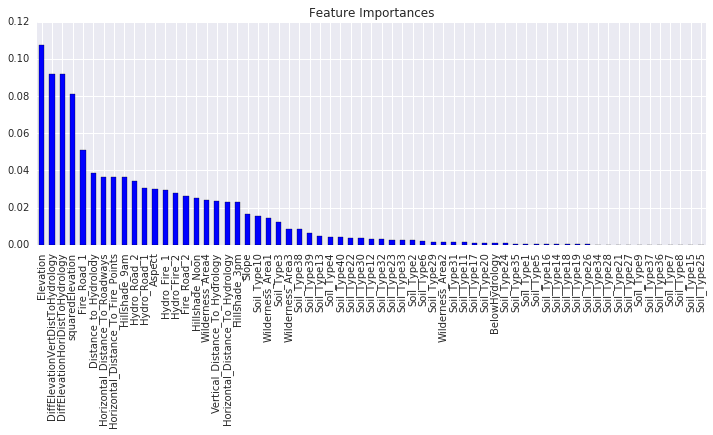

In [33]:
#let's try a simple Random Forest
def non_tuned_rfc():
    print 'Non-Tuned Random Forest'
    rfc = RandomForestClassifier(random_state=10)
    modelfit(rfc, X_fit, y_fit,printFeatureImportance=True)
    #Evaluate on development data
    preds = rfc.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    print metrics.classification_report(y_eval.values, preds)
    
non_tuned_rfc()

In [34]:
def tune_rfc():
    #Let's try tuning random forest
    #Start with max_features= sq.rt(features) - http://scikit-learn.org/stable/modules/ensemble.html (1.11.2.3)
    print "-------Find the best parameters for RandomForest-------------"
    tune_params = {'n_estimators': [400,500,600], 'max_features':[8,9,10,11,12,13,14,15]}
    clf = GridSearchCV(RandomForestClassifier(), tune_params)
    clf.fit(X_fit, y_fit)
    print 'Best parametrs for RandomForest:', clf.best_params_

tune_rfc()

-------Find the best parameters for RandomForest-------------
Best parametrs for RandomForest: {'max_features': 8, 'n_estimators': 500}


--------Trying tuned RandomForest---------------
CV (f1) Score : Mean - 0.8788941 | Std - 0.005697033 | Min - 0.8708899 | Max - 0.8877569 

Accuracy (Train): 1
oob score: 0.890211640212
Accuracy (Dev) : 0.8995
             precision    recall  f1-score   support

          1       0.82      0.78      0.80       215
          2       0.78      0.72      0.75       212
          3       0.91      0.91      0.91       227
          4       0.93      0.97      0.95       205
          5       0.95      0.97      0.96       234
          6       0.91      0.94      0.93       190
          7       0.98      1.00      0.99       229

avg / total       0.90      0.90      0.90      1512



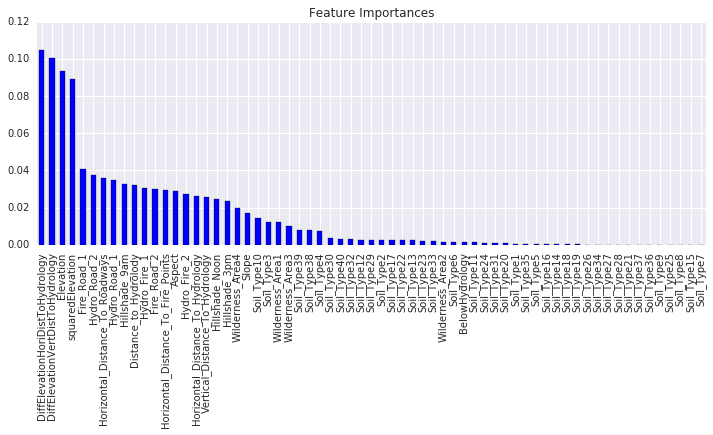

In [39]:
#The output from above - Best parametrs for RandomForest: {'max_features': 8, 'n_estimators': 500}
print '--------Trying tuned RandomForest---------------'
trfc = RandomForestClassifier(max_features=8, n_estimators=500, min_samples_split=1, random_state=10, 
                            oob_score=True, bootstrap=True, max_depth=None)
modelfit(trfc, X_fit, y_fit, performCV=True, printFeatureImportance=True)
print 'oob score:', trfc.oob_score_
#Evaluate on development data
preds = trfc.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)
#print metrics.confusion_matrix(y_eval.values, preds)

In [ ]:
def tune_extra_trees():
    #Let's try tuning random forest
    #Start with max_features= sq.rt(features) - http://scikit-learn.org/stable/modules/ensemble.html (1.11.2.3)
    print "-------Find the best parameters for ExtraTrees-------------"
    tune_params = {'n_estimators': [800,1000,1200], 'max_features':[8,9,10,11,12]}
    clf = GridSearchCV(ExtraTreesClassifier(), tune_params)
    clf.fit(X_fit, y_fit)
    print 'Best parametrs for ExtaTrees:', clf.best_params_

tune_extra_trees()

In [40]:
#Lets do some PCA to reduce the number of components. Let us draw a curve of explained variance vs number of components
#to see if PCA even makes sense in this case (has only few features)
def pca():
    pca_mod = PCA()
    pca_mod.fit(X_fit) 
    print 'variance:', pca_mod.explained_variance_ratio_
    explained_variance = np.cumsum(pca_mod.explained_variance_ratio_)
    print 'explained variance:', explained_variance
    plt.plot(explained_variance)
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.show()

    pca_mod = PCA(n_components = 9)
    X_fit_transformed = pca_mod.fit_transform(X_fit) 
    X_eval_transformed = pca_mod.transform(X_eval)
    explained_variance = np.cumsum(pca_mod.explained_variance_ratio_)
    print 'Fraction of the total variance explained: \n', explained_variance[len(explained_variance) - 1]

    trfc = RandomForestClassifier(max_features=9, n_estimators=100)
    modelfit(trfc, X_fit_transformed, y_fit,performCV=False,printFeatureImportance=False)
    #Evaluate on development data
    preds = trfc.predict(X_eval_transformed)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    print metrics.classification_report(y_eval.values, preds)
#PCA does not help - does not improve accuracy    
#pca()

Trying tuned ExtraTrees...
CV (f1) Score : Mean - 0.8860386 | Std - 0.003831176 | Min - 0.8790644 | Max - 0.889352 

Accuracy (Train): 1
oob score: 0.895723104056
F1 Score (Dev) : 0.9033
             precision    recall  f1-score   support

          1       0.83      0.80      0.82       215
          2       0.80      0.76      0.78       212
          3       0.91      0.90      0.91       227
          4       0.93      0.97      0.95       205
          5       0.96      0.97      0.96       234
          6       0.89      0.94      0.92       190
          7       0.99      0.98      0.98       229

avg / total       0.90      0.90      0.90      1512

[[172  38   0   0   2   0   3]
 [ 30 162   4   0   8   8   0]
 [  0   2 205  10   0  10   0]
 [  0   0   6 199   0   0   0]
 [  0   1   3   0 227   3   0]
 [  0   0   7   5   0 178   0]
 [  5   0   0   0   0   0 224]]


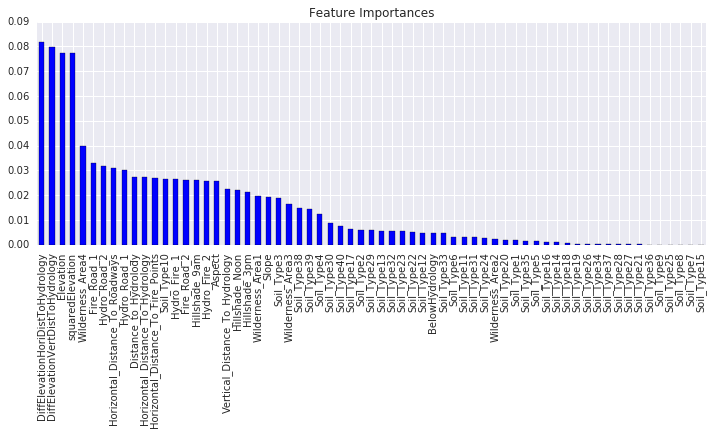

In [44]:
print 'Trying tuned ExtraTrees...'
etrfc = ExtraTreesClassifier(max_features=9, n_estimators=1200, oob_score=True, bootstrap=True, random_state=10)
modelfit(etrfc, X_fit, y_fit, performCV=True, printFeatureImportance=True)
print 'oob score:', etrfc.oob_score_
#Evaluate on development data
preds = etrfc.predict(X_eval)
print "F1 Score (Dev) : %.4g" % metrics.f1_score(y_eval.values, preds, average='weighted')
print metrics.classification_report(y_eval.values, preds)
print metrics.confusion_matrix(y_eval.values, preds)

The ExtraTrees model above is the best of all the models tried in this notebook. It gives a score of 0.7818 on the Kaggle Leader board (Rank = 343). The thing to note though is this:

This model gives an OOB Score (Out of bag score) of 0.89 - The out of bag score is a good measure to figure out how the model predicts unseen test data (Because that score captures how the samples were predicted by trees which did not have that sample). Even though the dev accuracy is around 0.89 and the OOB is 0.89, the leader board score is 0.78. The reason is that the test data is different from the training data. Training data has the equal number of all labels. Test data has predominantly 1 and 2 classes. And, if you notice the classification report and confusion matrix above, 1 and 2 classes do the worst in the dev data. That happens irrespective of any amount of tuning. That could be offset a bit by creating features which differentiate those 2 classes better.

In [45]:
def find_confused_pairs():
    confusion = metrics.confusion_matrix(y_eval.values, preds)
    print 'confusion matrix:'
    print confusion
    confusion_transpose = np.transpose(confusion)
    confusion_sum = confusion + confusion_transpose
    #create a new matrix of the same shape as confusion_sum with ones.
    mask = np.ones(confusion_sum.shape, dtype=bool)
    #fill up the diagonal with 0, so that we dont count them in the max.
    np.fill_diagonal(mask, 0)
    #find the max
    max_value = confusion_sum[mask].max()
    print max_value
    #find the locations where the max is found - which is the pairs of digits most confused
    print np.where(confusion_sum == max_value)
find_confused_pairs()

confusion matrix:
[[172  38   0   0   2   0   3]
 [ 30 162   4   0   8   8   0]
 [  0   2 205  10   0  10   0]
 [  0   0   6 199   0   0   0]
 [  0   1   3   0 227   3   0]
 [  0   0   7   5   0 178   0]
 [  5   0   0   0   0   0 224]]
68
(array([0, 1], dtype=int64), array([1, 0], dtype=int64))


In [46]:
def test_rfc(features, weight, estimators):
    model = 'Number of features:'+ str(features) + ', Number of estimators:' + str(estimators) + ', Weight:' + weight
    print model
    trfc = RandomForestClassifier(max_features=features, n_estimators=estimators, min_samples_split=1, random_state=10, 
                            oob_score=True, bootstrap=True, max_depth=None, class_weight=weight)
    #trfc = ExtraTreesClassifier(max_features=7, n_estimators=500, min_samples_split=1, random_state=10, 
    #                            oob_score=True, bootstrap=True, max_depth=None)
    modelfit(trfc, X_fit, y_fit, performCV=False, printFeatureImportance=False)
    print 'oob score:', trfc.oob_score_
    #Evaluate on development data
    preds = trfc.predict(X_eval)
    print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
    
    print '--------------------------------------------------------'
    
def try_few_params_rfc():
    for features in range(6,9):
         for estimators in [400,500,600]:
            for weight in ['balanced', 'balanced_subsample']:
                test_rfc(features, weight, estimators)
            
#Test code to try different combinations of rfc and report accuracy and oob score
#try_few_params_rfc()

------------------------------------------GBM----------------------------------------

In [11]:
#Now let's tune GBM

#Tuning to find appropriate number of trees, keeping a relatively high learning rate

param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, \
                                                               min_samples_split=500,\
                                                               min_samples_leaf=50,\
                                                               max_depth=8,max_features='sqrt',\
                                                               subsample=0.8,\
                                                               random_state=10), 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_fit,y_fit)
#Check Output
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.72938, std: 0.01271, params: {'n_estimators': 20},
  mean: 0.74987, std: 0.01214, params: {'n_estimators': 30},
  mean: 0.76240, std: 0.01042, params: {'n_estimators': 40},
  mean: 0.77349, std: 0.01174, params: {'n_estimators': 50},
  mean: 0.78078, std: 0.01275, params: {'n_estimators': 60},
  mean: 0.78457, std: 0.01180, params: {'n_estimators': 70},
  mean: 0.78968, std: 0.01111, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.78967526994597514)

In [12]:
#Let's go with n_estimators=80 for now
#Tune to get max_depth and min_samples_split
param_test2 = {'max_depth':range(1,10,2), 'min_samples_split':range(2,10,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, \
                                                               max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_fit,y_fit)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.67660, std: 0.01691, params: {'min_samples_split': 2, 'max_depth': 1},
  mean: 0.67660, std: 0.01691, params: {'min_samples_split': 4, 'max_depth': 1},
  mean: 0.67660, std: 0.01691, params: {'min_samples_split': 6, 'max_depth': 1},
  mean: 0.67660, std: 0.01691, params: {'min_samples_split': 8, 'max_depth': 1},
  mean: 0.75533, std: 0.00891, params: {'min_samples_split': 2, 'max_depth': 3},
  mean: 0.75593, std: 0.01141, params: {'min_samples_split': 4, 'max_depth': 3},
  mean: 0.75355, std: 0.00943, params: {'min_samples_split': 6, 'max_depth': 3},
  mean: 0.75451, std: 0.01004, params: {'min_samples_split': 8, 'max_depth': 3},
  mean: 0.80552, std: 0.01014, params: {'min_samples_split': 2, 'max_depth': 5},
  mean: 0.80237, std: 0.01139, params: {'min_samples_split': 4, 'max_depth': 5},
  mean: 0.79963, std: 0.00946, params: {'min_samples_split': 6, 'max_depth': 5},
  mean: 0.80398, std: 0.01199, params: {'min_samples_split': 8, 'max_depth': 5},
  mean: 0.82457, std: 0.0069

In [13]:
#Let's go wtih min_samples_split = 6
#Now tune min_samples_split,min_samples_leaf

param_test3 = {'max_depth':range(9,25,2), 'min_samples_leaf':range(10,51,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, \
                                                               min_samples_split = 6, 
                                                               n_estimators=80,max_features='sqrt', \
                                                               subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83981, std: 0.00345, params: {'max_depth': 9, 'min_samples_leaf': 10},
  mean: 0.83466, std: 0.00356, params: {'max_depth': 9, 'min_samples_leaf': 20},
  mean: 0.83033, std: 0.00511, params: {'max_depth': 9, 'min_samples_leaf': 30},
  mean: 0.82795, std: 0.00302, params: {'max_depth': 9, 'min_samples_leaf': 40},
  mean: 0.82421, std: 0.00318, params: {'max_depth': 9, 'min_samples_leaf': 50},
  mean: 0.84458, std: 0.00337, params: {'max_depth': 11, 'min_samples_leaf': 10},
  mean: 0.84191, std: 0.00500, params: {'max_depth': 11, 'min_samples_leaf': 20},
  mean: 0.83810, std: 0.00300, params: {'max_depth': 11, 'min_samples_leaf': 30},
  mean: 0.83201, std: 0.00547, params: {'max_depth': 11, 'min_samples_leaf': 40},
  mean: 0.82912, std: 0.00274, params: {'max_depth': 11, 'min_samples_leaf': 50},
  mean: 0.84874, std: 0.00404, params: {'max_depth': 13, 'min_samples_leaf': 10},
  mean: 0.84311, std: 0.00348, params: {'max_depth': 13, 'min_samples_leaf': 20},
  mean: 0.84064, std:

In [14]:
#Next tune max_features, subsample
param_test4 = {'max_features':range(5,40,5),'subsample':[0.6,0.7,0.75,0.8,0.85,0.9] }
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, \
                                                               min_samples_split = 6, 
                                                               max_depth =17 , min_samples_leaf = 10,
                                                               n_estimators=80, \
                                                               random_state=10), 
param_grid = param_test4, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.84021, std: 0.00418, params: {'max_features': 5, 'subsample': 0.6},
  mean: 0.84237, std: 0.00306, params: {'max_features': 5, 'subsample': 0.7},
  mean: 0.84624, std: 0.00632, params: {'max_features': 5, 'subsample': 0.75},
  mean: 0.84604, std: 0.00360, params: {'max_features': 5, 'subsample': 0.8},
  mean: 0.84416, std: 0.00387, params: {'max_features': 5, 'subsample': 0.85},
  mean: 0.84625, std: 0.00382, params: {'max_features': 5, 'subsample': 0.9},
  mean: 0.85200, std: 0.00113, params: {'max_features': 10, 'subsample': 0.6},
  mean: 0.85690, std: 0.00308, params: {'max_features': 10, 'subsample': 0.7},
  mean: 0.85515, std: 0.00116, params: {'max_features': 10, 'subsample': 0.75},
  mean: 0.85503, std: 0.00309, params: {'max_features': 10, 'subsample': 0.8},
  mean: 0.86103, std: 0.00314, params: {'max_features': 10, 'subsample': 0.85},
  mean: 0.85852, std: 0.00214, params: {'max_features': 10, 'subsample': 0.9},
  mean: 0.85791, std: 0.00235, params: {'max_features'

CV (f1) Score : Mean - 0.8601912 | Std - 0.008810201 | Min - 0.8470491 | Max - 0.8723213 

Accuracy (Train): 1
Accuracy (Dev) : 0.8618
             precision    recall  f1-score   support

          1       0.76      0.76      0.76       635
          2       0.79      0.68      0.73       684
          3       0.86      0.81      0.84       652
          4       0.94      0.98      0.96       590
          5       0.89      0.97      0.93       659
          6       0.84      0.88      0.86       641
          7       0.94      0.96      0.95       675

avg / total       0.86      0.86      0.86      4536



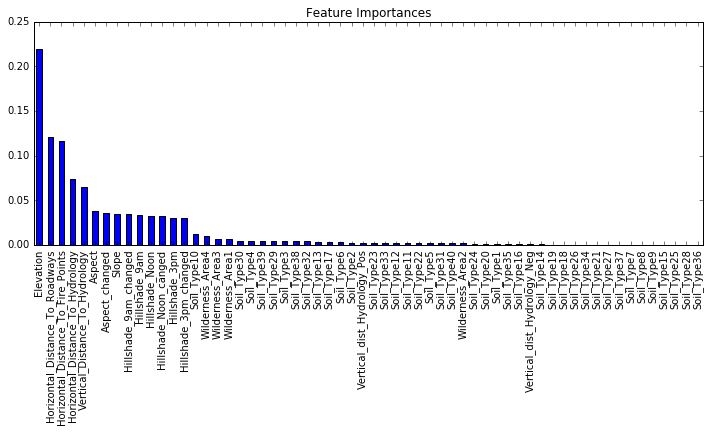

In [15]:
#First tuned GBM Model
#Then, decrease learning rate by half and increase num_trees by doubling
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160, 
                                          min_samples_split = 6, 
                                          max_depth =17 , min_samples_leaf =10 , max_features=35,subsample=0.9,
                                          random_state=10)

modelfit(gbm_tuned_1, X_fit, y_fit,printFeatureImportance=True)
#Evaluate on development data
preds = gbm_tuned_1.predict(X_eval)
print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

In [17]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    labels = np.sort(y_fit.unique())
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


CV (f1) Score : Mean - 0.8591428 | Std - 0.00534976 | Min - 0.8511115 | Max - 0.8650962 

Accuracy (Train): 1
Accuracy (Dev) : 0.8706
             precision    recall  f1-score   support

          1       0.79      0.76      0.77       609
          2       0.77      0.71      0.74       620
          3       0.87      0.82      0.84       666
          4       0.94      0.98      0.96       675
          5       0.92      0.94      0.93       662
          6       0.84      0.88      0.86       639
          7       0.94      0.97      0.95       665

avg / total       0.87      0.87      0.87      4536



NameError: name 'confusion_matrix' is not defined

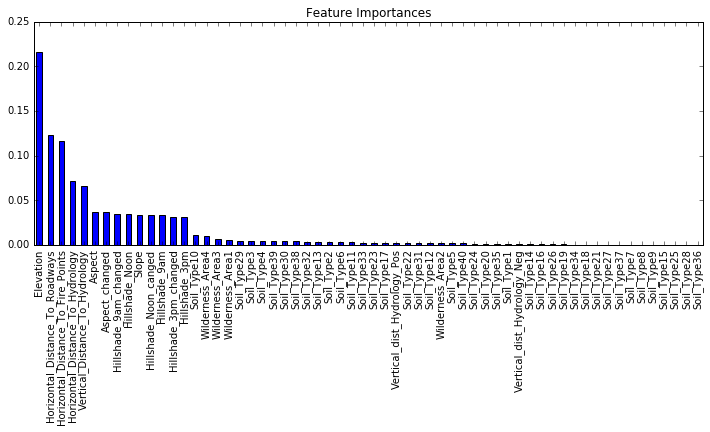

In [11]:
#Then, decrease original learning rate by five and increase num_trees by five
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.02, n_estimators=400, 
                                          min_samples_split = 6, 
                                          max_depth =17 , min_samples_leaf =10 , max_features=35,subsample=0.9,
                                          random_state=10)

modelfit(gbm_tuned_2, X_fit, y_fit,printFeatureImportance=True)

#Evaluate on development data
preds = gbm_tuned_2.predict(X_eval)

print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

In [ ]:
#Then, decrease original learning rate by five and increase num_trees by five
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=800, 
                                          min_samples_split = 6, 
                                          max_depth =17 , min_samples_leaf =10 , max_features=35,subsample=0.9,
                                          random_state=10)

modelfit(gbm_tuned_3, X_fit, y_fit,printFeatureImportance=True)

#Evaluate on development data
preds = gbm_tuned_3.predict(X_eval)

print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

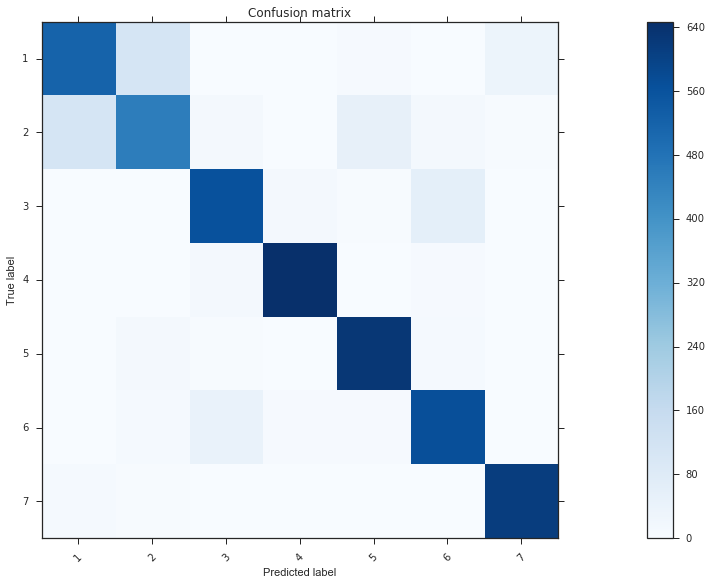

In [45]:
plot_confusion_matrix(metrics.confusion_matrix(y_eval.values, preds))

Most confusion in labels is happening between labels 1 and 2. Next highest is between 3 and 6.

CV (f1) Score : Mean - 0.8623386 | Std - 0.008979893 | Min - 0.8511941 | Max - 0.8772539 

Accuracy (Train): 1
Accuracy (Dev) : 0.8783
             precision    recall  f1-score   support

          1       0.81      0.77      0.79       671
          2       0.77      0.70      0.73       644
          3       0.88      0.86      0.87       645
          4       0.97      0.97      0.97       665
          5       0.89      0.96      0.93       654
          6       0.86      0.90      0.88       634
          7       0.94      0.98      0.96       623

avg / total       0.88      0.88      0.88      4536



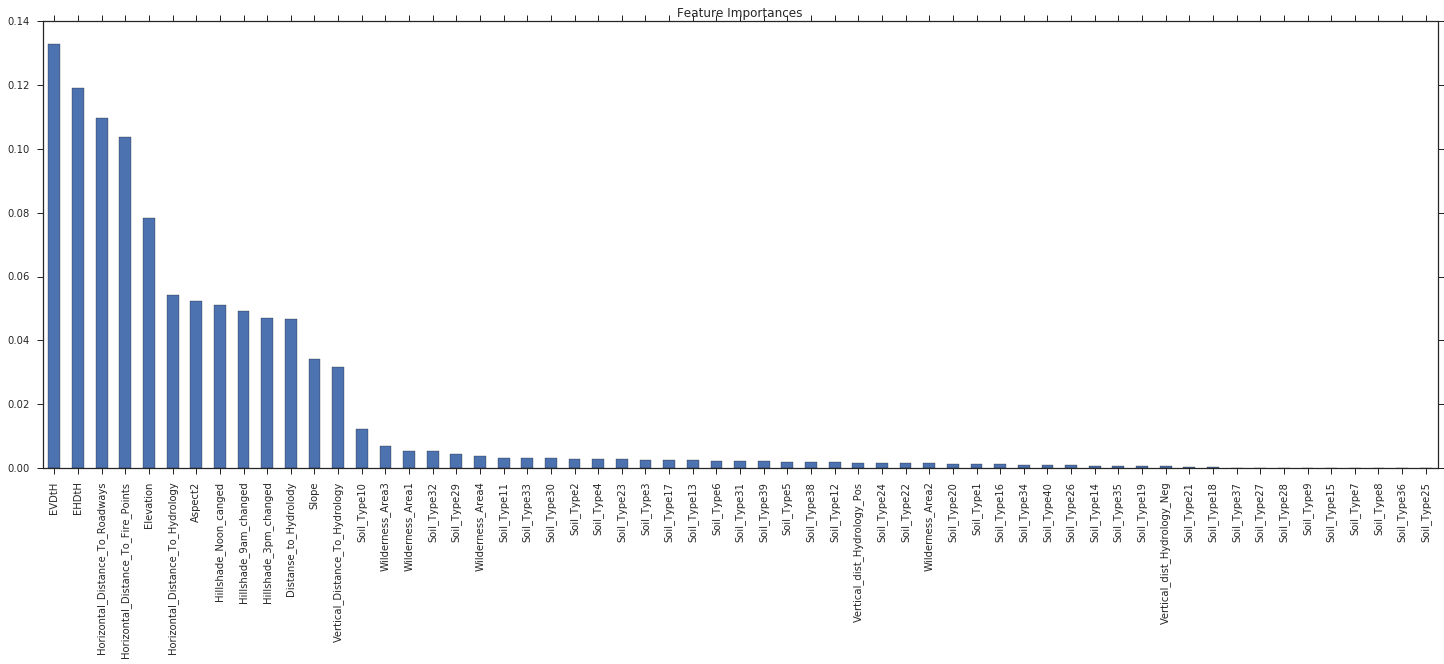

In [47]:
#change max depth and n_estimators
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, 
                                          min_samples_split = 6, 
                                          max_depth =10 , min_samples_leaf =10 , max_features=35,subsample=0.9,
                                          random_state=10)

modelfit(gbm_tuned_4, X_fit, y_fit,printFeatureImportance=True)

#Evaluate on development data
preds = gbm_tuned_4.predict(X_eval)

print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

Let's go back to the best model so far which is gbm_tined_3

-------------------------------------Combine Best RFC and Best GBM using Majority Vote Classifier-------------------------------

In [51]:
#Majority vote classifier
'''
Implement Majority Vote Classifier from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch07/ch07.ipynb
'''

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out



In [52]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[gbm_tuned_3, etrfc])
#print mv_clf.get_params()
modelfit(mv_clf, X_fit, y_fit,printFeatureImportance=False)

#Evaluate on development data
preds = mv_clf.predict(X_eval)

print "Accuracy (Dev) : %.4g" % metrics.accuracy_score(y_eval.values, preds)
print metrics.classification_report(y_eval.values, preds)

Accuracy (Dev) : 0.8796
             precision    recall  f1-score   support

          1       0.78      0.82      0.80       671
          2       0.78      0.68      0.73       644
          3       0.84      0.91      0.88       645
          4       0.97      0.97      0.97       665
          5       0.92      0.95      0.94       654
          6       0.89      0.86      0.87       634
          7       0.96      0.97      0.96       623

avg / total       0.88      0.88      0.88      4536



The best model so far is 
Let's submit on Kaggle Public leaderboard

In [54]:
#Submission of test values -- Run this once after finalizing model
preds = mv_clf.predict(test[predictors])

submission = pd.DataFrame({"Id":test[IDcol], "Cover_Type":preds})
submission.to_csv("submission_fe1_mvclf.csv", index=False)

This scored 0.757 on the Public LB, with rank placing this submission in top x%